In [280]:
import os
import pandas as pd
from math import ceil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker
#pd.show_versions(as_json=False)

threshold = 1000

In [281]:
# Load Data
datapath = '../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    
raw = pd.read_csv(datapath)
del raw['Lat']
del raw['Long']
raw= raw.replace('Mainland China','China')
raw

,Province/State,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20
0,NaN,Afghanistan,0,0,0,0,0,0,0,0,...,22,22,24,24,40,40,74,84,94,110
1,NaN,Albania,0,0,0,0,0,0,0,0,...,59,64,70,76,89,104,123,146,174,186
2,NaN,Algeria,0,0,0,0,0,0,0,0,...,74,87,90,139,201,230,264,302,367,409
3,NaN,Andorra,0,0,0,0,0,0,0,0,...,39,53,75,88,113,133,164,188,224,267
4,NaN,Angola,0,0,0,0,0,0,0,0,...,0,0,1,2,2,3,3,3,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,NaN,Saint Kitts and Nevis,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,2,2
245,Northwest Territories,Canada,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
246,Yukon,Canada,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,3
247,NaN,Kosovo,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,71,86


In [282]:
# Shift all the series
def shift(df, threshold=1000):
    maxDate = max(df.index)    
    for c in df.columns:
        for i,a in enumerate(df[c]):        
            if i==0 and a>threshold:
                df[c]=df[c].shift(4) # hack to push out china
                break
            if a>=threshold:
                df[c]=df[c].shift(-i)            
                break
    df=df.reset_index(drop=True)
    #del df['China']
    return df


In [283]:
%matplotlib inline
from math import pow

plt.rcParams["figure.figsize"] = [10, 10]
def plotdataframe(df, logy=False, legend=True):
    fig, ax = plt.subplots()
    markers = [item for sublist in ['oxds+*']*ceil(len(df.columns)/5) for item in sublist]    
    for c,m in zip(df,markers):
        df[c].plot(logy=logy, marker=m, fontsize=12,ax=ax, linewidth=2.5)
    
    font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)
    legend and ax.legend(prop=font)

    return ax

def plotdataframe_point(df, logy=False, legend=True, legend_loc='best'):
    fig, ax = plt.subplots()
    markers = [item for sublist in ['oxds+*']*ceil(len(df.columns)/5) for item in sublist]    
    lines = []
    legendcols = []
    for c,m in zip(df,markers):
        pts = list([x for (x,y) in zip(df.index,df[c]) if y>0])
        ys = list([x for x in df[c] if x>0])
        if len(pts)<=1:
            continue
        legendcols.append(c)
        df[c].plot(logy=logy, marker=m, fontsize=12,ax=ax, linewidth=1, color='#999999')
        
        offset = (10,0)
        #print([pts[0],pts[-1]],[ys[0],ys[-1]])
        l,=ax.plot([pts[0],pts[-1]],[ys[0],ys[-1]], linewidth=2.5, marker=m)
        lines.append(l)
        growth = round((pow(ys[-1]/ys[0],1.0/(pts[-1]-pts[0]))-1)*100)
        ax.annotate('{} ({}%)'.format(c,growth), xy=(pts[-1],ys[-1]), xytext=offset, textcoords='offset points', size=12)
    
    if logy:
        ax.get_yaxis().set_major_formatter(
            ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)
    legend and ax.legend(lines,legendcols,prop=font, loc=legend_loc)

    return ax

def save_figure(maxDate, filename):
    savedir = os.path.join('data',maxDate.strftime('%Y%m%d'))
    if not os.path.isdir(savedir):
        os.makedirs(savedir)
    plt.savefig(os.path.join(savedir,filename))


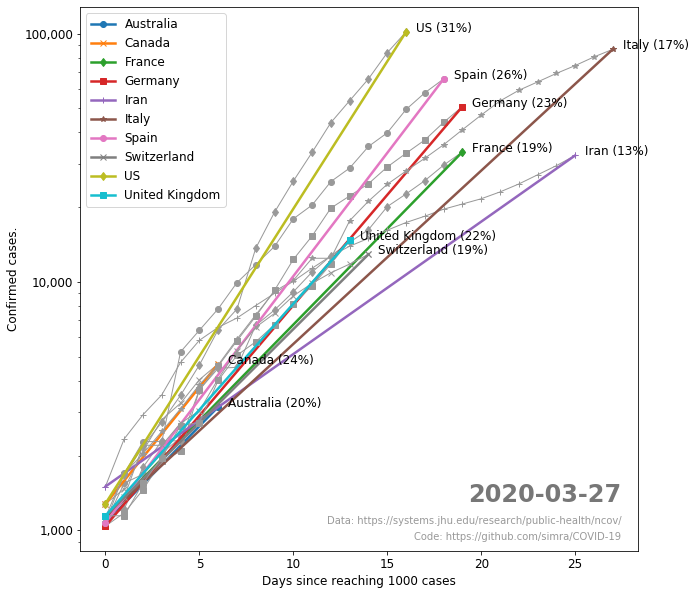

In [284]:
df=raw.groupby('Country/Region').sum()
last_date = list(df.columns)[-1]

df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
    #del df['Cruise Ship']

threshold = 1000
del df['China']
df = df[[c for c in df.columns if df[c].max()>10000 or c in ['Canada','US', 'Australia']]]
maxDate = max(df.index)
df = shift(df)

ax=plotdataframe_point(df, logy=True)
ax.set_xlabel("Days since reaching {} cases".format(threshold), size=12)
ax.set_ylabel("Confirmed cases." , size=12)
ax.text(0.97, 0.09, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='right', weight=800)
ax.text(0.97, 0.05, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.02, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
save_figure(maxDate,'1_countryshift.png')


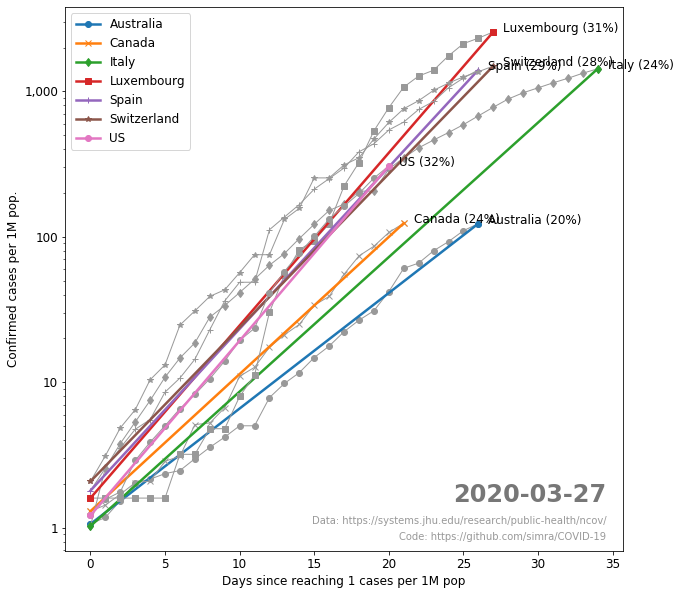

In [285]:
# Try normalizing by population
# https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/WPP2019_TotalPopulationBySex.csv
wpp = pd.read_csv('../wpp/WPP2019_TotalPopulationBySex.csv')
wpp=wpp[(wpp['Time']==2020) & (wpp['Variant']=='Medium')]
wpp = dict(zip(wpp['Location'],wpp['PopTotal']))
wpp['Iran']=wpp['Iran (Islamic Republic of)']
wpp['US']=wpp['United States of America']
wpp['Korea, South']= wpp['Republic of Korea']
wpp['Russia'] = wpp['Russian Federation']

df=raw.groupby('Country/Region').sum()
last_date = list(df.columns)[-1]

df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
    #del df['Cruise Ship']

    
df = df[[c for c in df.columns if df[c].max()>1000 or c in ['Canada','US', 'Australia']]]
for c in df.columns:
    df[c] = df[c]*1000/wpp[c]
df = df[[c for c in df.columns if df[c].max()>1000 or c in ['Canada','US', 'Australia']]]

#plotdataframe(df, logy=True)
maxDate = max(df.index)
threshold = 1
df= shift(df,threshold=threshold)

ax=plotdataframe_point(df, logy=True)
ax.set_xlabel("Days since reaching {} cases per 1M pop".format(threshold), size=12)
ax.set_ylabel("Confirmed cases per 1M pop." , size=12)
ax.text(0.97, 0.09, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='right', weight=800)
ax.text(0.97, 0.05, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.02, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
save_figure(maxDate,'2_countryshift_norm.png')

#wpp

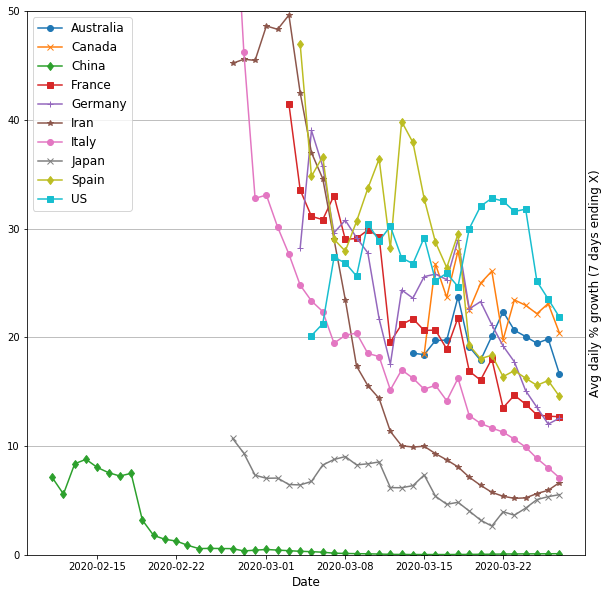

In [286]:
df=raw.groupby('Country/Region').sum()
# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]

df = df[(df.index.isin(['Canada','Japan', 'Australia'])) | (df[last_date]>20000)]

df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
#del df['Cruise Ship']
maxDate=max(df.index)

plt.rcParams["figure.figsize"] = [10, 10]
fig, ax = plt.subplots()
growth = {}
markers = [item for sublist in ['oxds+*']*ceil(len(df.columns)/5) for item in sublist]    
for c,m in zip(df.columns,markers):
    growth[c] = [(pow(df[c][i]/max(1.0,df[c][i-6]),1.0/7)-1)*100 if df[c][i]>200 else float('nan') for i in range(20,len(df[c]))]
    #growth[c] = [growth[c][i] if growth[c][i]<100 else float('nan') for i in range(len(growth[c]))]
    ax.plot(df.index[20:], growth[c], marker=m)

    
font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)


ax.grid(axis='y') 
ax.yaxis.set_label_position("right")
ax.set_ylim([0,50])
ax.set_xlabel('Date', size=12)
ax.set_ylabel('Avg daily % growth (7 days ending X)', size=12)
ax.legend(df.columns, prop=font)    
#plt.ylim((0,100))
save_figure(maxDate,'3_growth.png')

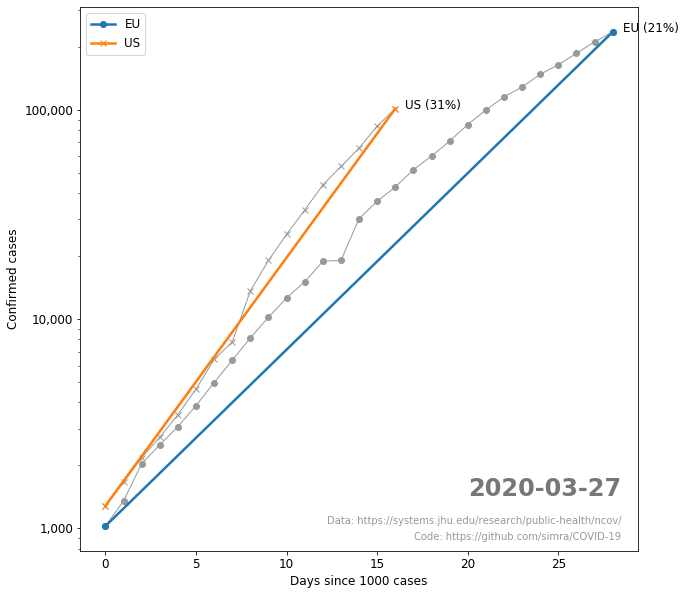

In [287]:
df=raw.groupby('Country/Region').sum()
# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]

#df = df[(df.index.isin(['Canada','Japan'])) | (df[last_date]>4000)]
df = df[df.index.isin(['US','France','Germany','Italy','Spain', 'UK'])]
df = df.groupby(df.index=='US').sum()
df.index = ['US' if c else 'EU' for c in df.index]
df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
#del df['Cruise Ship']
maxDate = max(df.index)
threshold = 1000
df=shift(df,threshold=threshold)
ax=plotdataframe_point(df, logy=True)

ax.set_xlabel('Days since {} cases'.format(threshold), size=12)
ax.set_ylabel('Confirmed cases', size=12)
ax.text(0.97, 0.1, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='right', weight=800)
ax.text(0.97, 0.05, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.02, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

save_figure(maxDate, '6_euus.png')

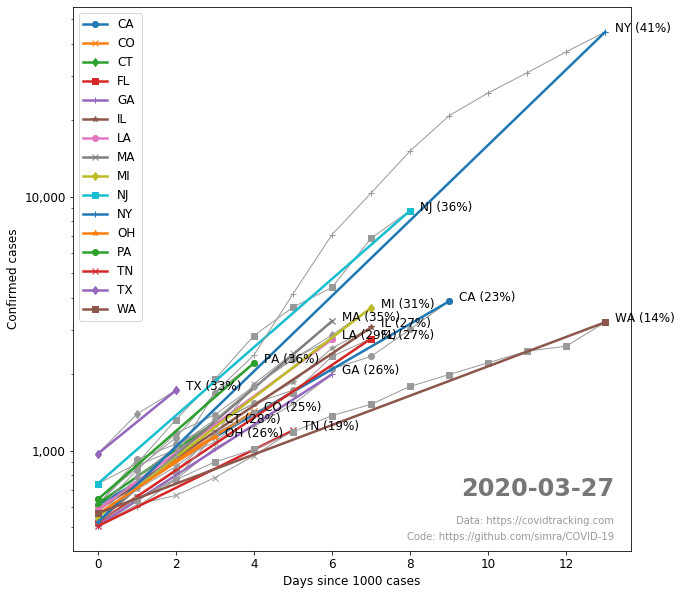

In [288]:
covidtracking = pd.read_csv('../other3p/covidtracking_daily.csv')
covidtracking['date'] = pd.to_datetime(covidtracking['date'],format="%Y%m%d")
maxDate = max(covidtracking['date'])
df = covidtracking.pivot(index='date',columns='state', values='positive')
df = df[[c for c in df.columns if df[c].max()>1000]]

shift_threshold = 500
df = shift(df, threshold=shift_threshold)

ax=plotdataframe_point(df, logy=True)


ax.set_xlabel('Days since {} cases'.format(threshold), size=12)
ax.set_ylabel('Confirmed cases', size=12)
ax.text(0.97, 0.1, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='right', weight=800)
ax.text(0.97, 0.05, 'Data: https://covidtracking.com', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.02, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

save_figure(maxDate,'9_usstates.png')


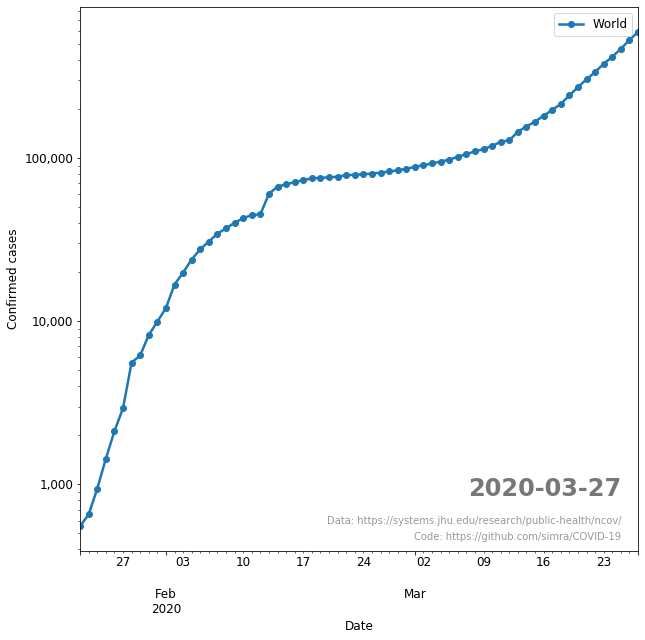

In [289]:
df=raw.groupby(lambda x: True).sum()
# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]

#df = df[(df.index.isin(['Canada','Japan'])) | (df[last_date]>4000)]
#df = df[df.index.isin(['US','France','Germany','Italy','Spain'])]
#df = df.groupby(df.index=='US').sum()
df.index = ['World']
df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
maxDate = max(df.index)
#del df['Cruise Ship']
#df=shift(df)
df
ax=plotdataframe(df, logy=True)
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlabel('Date', size=12)
ax.set_ylabel('Confirmed cases', size=12)
ax.text(0.97, 0.1, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='right', weight=800)
ax.text(0.97, 0.05, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.02, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

save_figure(maxDate,'7_world.png')

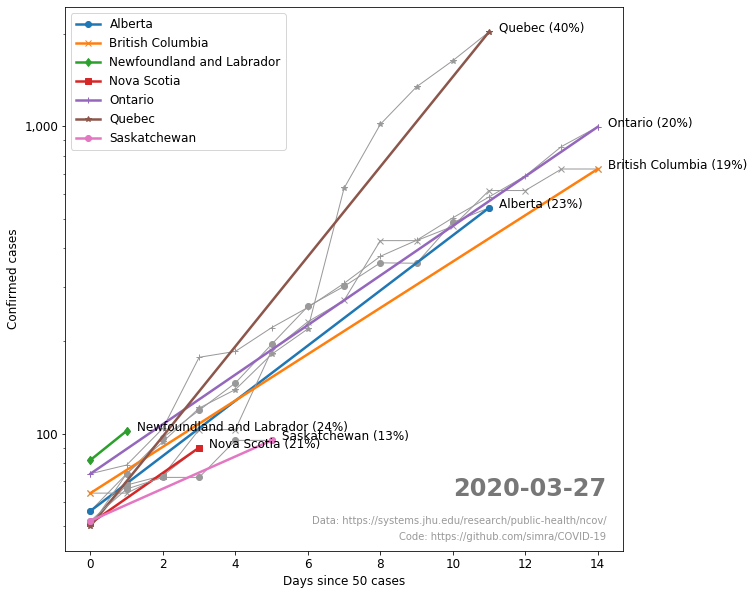

In [290]:
df = raw[raw['Country/Region']=='Canada']
df=df.groupby('Province/State').sum()
# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]
threshold=50
df = df[df[last_date]>threshold]
#df = df[df.index.isin(['US','France','Germany','Italy','Spain'])]
#df = df.groupby(df.index=='US').sum()
#df.index = ['World']

df['Province/State']=df.index
df=df.melt(id_vars='Province/State',var_name='date', value_name='Confirmed').pivot(index='date',columns='Province/State')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
for c in ['Recovered', 'Diamond Princess', 'Grand Princess']:
    if c in df:
        del df[c] 

maxDate = max(df.index)
df=shift(df,threshold)
df
ax=plotdataframe_point(df, logy=True, legend_loc='upper left')
ax.set_xlabel('Days since {} cases'.format(threshold), size=12)
ax.set_ylabel('Confirmed cases', size=12)
ax.text(0.97, 0.1, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='right', weight=800)
ax.text(0.97, 0.05, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.02, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

save_figure(maxDate, '8_canada.png')

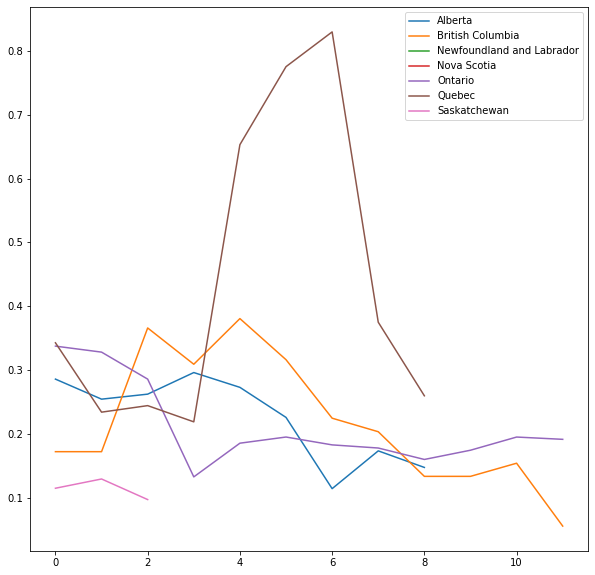

In [291]:
from math import pow
cdn_growth = {}

gdf = df
for c in gdf.columns:
    cdn_growth[c]=[]
    for i in range(3,len(gdf[c])):        
        if not np.isnan(gdf[c][i] and gdf[c][i]>2000):                          
            cdn_growth[c].append(pow(gdf[c][i]/gdf[c][i-3],1.0/3)-1.0)
            
fig,ax = plt.subplots()
for c in cdn_growth:
    ax.plot(cdn_growth[c])
ax.legend(cdn_growth.keys())

In [292]:
# US and Canada 
df=raw
# temporarily drop 03/14
#del df[df.columns[-1]]
df = df[df['Country/Region'].isin(['Canada','US','Italy'])]

df=df.groupby('Country/Region').sum()


df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)


df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
df

,Canada,Italy,US
date,,,
2020-01-22,0,0,1
2020-01-23,0,0,1
2020-01-24,0,0,2
2020-01-25,0,0,2
2020-01-26,1,0,5
...,...,...,...
2020-03-23,2088,63927,43847
2020-03-24,2790,69176,53740
2020-03-25,3251,74386,65778


In [293]:
#https://stackoverflow.com/questions/54376900/fit-sigmoid-curve-in-python

from scipy.optimize import curve_fit
import numpy as np
from scipy.optimize import differential_evolution
import warnings

yData = df['US']
xData = range(len(yData))

def sigmoid(x, amplitude, x0, k):
    return amplitude**2/(1.0+np.exp(-(x-k)/x0))


# function for genetic algorithm to minimize (sum of squared error)
def sumOfSquaredError(parameterTuple):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    val = sigmoid(xData, *parameterTuple)
    return np.sum((yData - val) ** 2.0)


def generate_Initial_Parameters():
    # min and max used for bounds
    maxX = max(xData)
    minX = min(xData)
    maxY = max(yData)
    minY = min(yData)

    parameterBounds = []
    parameterBounds.append([minY**2, maxY**2]) # search bounds for amplitude
    parameterBounds.append([1.0/maxX, 1e6]) # search bounds for x0
    parameterBounds.append([minX, maxX]) # search bounds for k

    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
    return result.x, np.array(parameterBounds).T

# by default, differential_evolution completes by calling curve_fit() using parameter bounds
geneticParameters, bounds = generate_Initial_Parameters()
print(geneticParameters)
# now call curve_fit without passing bounds from the genetic algorithm,
# just in case the best fit parameters are aoutside those bounds
popt, pcov = curve_fit(sigmoid, xData, yData, geneticParameters, bounds=[[0,0,0],[np.inf,np.inf,np.inf]],maxfev=10000)
sigma = np.sqrt(np.diag(pcov)) 
print('Fitted parameters: {} Cov: {} Sigma: {}'.format(popt, pcov,sigma))
print()

modelPredictions = sigmoid(xData, *popt) 

absError = modelPredictions - yData

SE = np.square(absError) # squared errors
MSE = np.mean(SE) # mean squared errors
RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (np.var(absError) / np.var(yData))

print()
print('RMSE:', RMSE)
print('R-squared:', Rsquared)

xModel = np.linspace(min(xData), min(xData)+90)



[1.19934389e+02 1.94531831e+05 4.99720684e+01]
Fitted parameters: [467.09140817   3.1266777   65.47010724] Cov: [[1.37596126e+02 6.18350574e-01 3.30996881e+00]
 [6.18350574e-01 3.24490553e-03 1.52864411e-02]
 [3.30996881e+00 1.52864411e-02 8.02203990e-02]] Sigma: [11.73013751  0.05696407  0.28323206]


RMSE: 533.4937989454039
R-squared: 0.9992651139966843


In [294]:
# estimate the uncertainty range of the parameters.
L=np.linalg.cholesky(pcov).T
print(popt)
print(L)
eps = 1
[popt-L.dot([eps,0,0]),
 popt+L.dot([eps,0,0]),
 popt-L.dot([0,eps,0]),
 popt+L.dot([0,eps,0]),
 popt-L.dot([0,0,eps]),
 popt+L.dot([0,0,eps])]

# note we use epsilon = 0.5 instead of 1 stanard deviation. 
# The true distribution is asymmetric and heavy-tailed, so we end up with bad estimates for the amplitude.

[467.09140817   3.1266777   65.47010724]
[[11.73013751  0.05271469  0.28217647]
 [ 0.          0.02158858  0.01906543]
 [ 0.          0.          0.01527571]]


[array([455.36127066,   3.1266777 ,  65.47010724]),
 array([478.82154568,   3.1266777 ,  65.47010724]),
 array([467.03869348,   3.10508912,  65.47010724]),
 array([467.14412286,   3.14826629,  65.47010724]),
 array([466.8092317 ,   3.10761227,  65.45483153]),
 array([467.37358464,   3.14574314,  65.48538295])]

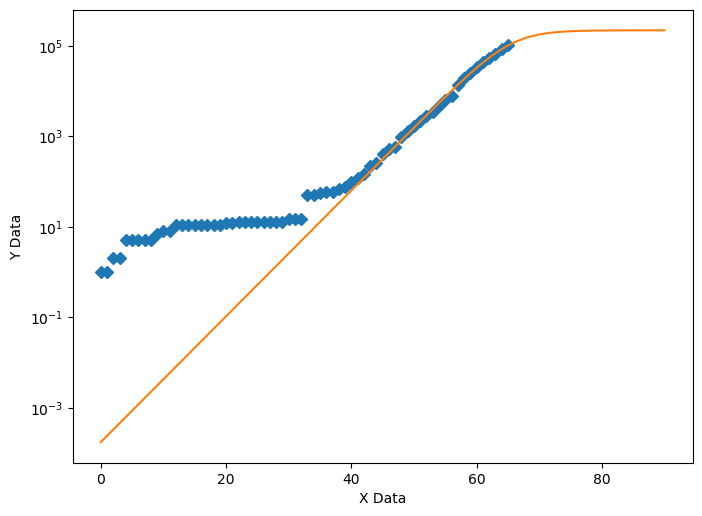

In [295]:
def ModelAndScatterPlot(graphWidth, graphHeight):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(xData, yData,  'D')

    # create data for the fitted equation plot    
    yModel = sigmoid(xModel, *popt)

    # now the model as a line plot
    axes.plot(xModel, yModel)
    axes.set_yscale('log')
    axes.set_xlabel('X Data') # X axis data label
    axes.set_ylabel('Y Data') # Y axis data label

    plt.show()
    plt.close('all') # clean up after using pyplot

graphWidth = 800
graphHeight = 600
ModelAndScatterPlot(graphWidth, graphHeight)

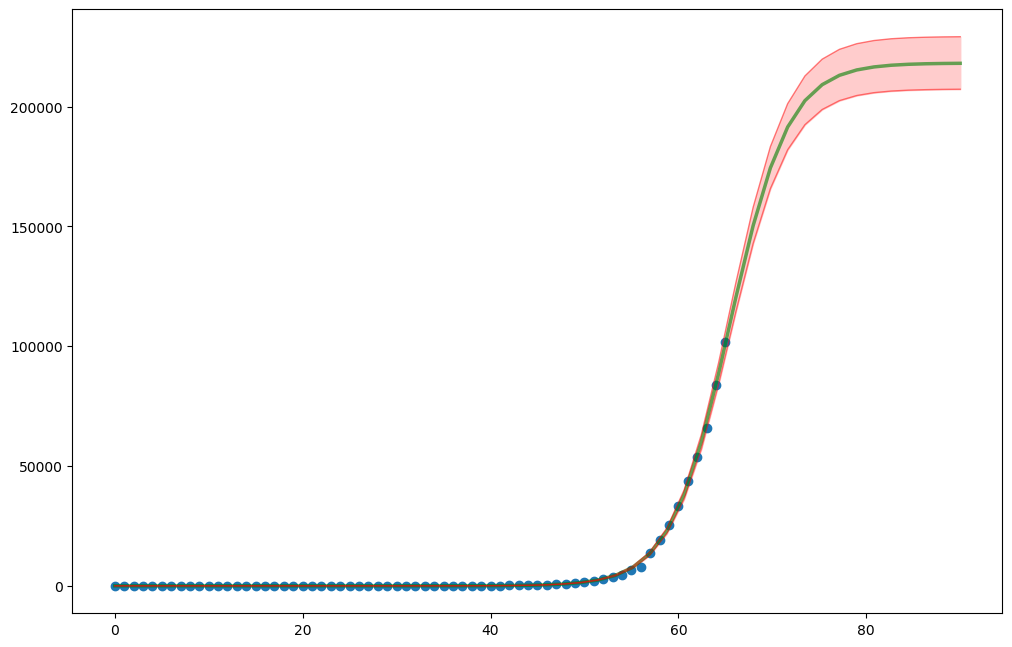

In [296]:
# Plot the best fit sigmoid and uncertainty region.

fig = plt.figure(figsize=(12,8), dpi=100, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
curveFit = sigmoid(xData,*popt)
curveFitModel = sigmoid(xModel,*popt)
plt.plot(xData, yData, 'o')
#plt.hold(True)
plt.plot(xModel, curveFitModel, 
    linewidth=2.5, 
    color = 'green',
    alpha = 0.6) #,
    #label = fitEquation)

maxes = None
mins = None

for p in [ [0,eps,0], [eps,0,0], [0,0,eps]]:
    params = popt+L.dot(p)
    s= sigmoid(xModel,*params)
    #plt.plot(xModel, s, linewidth= 1.0, alpha = 0.5, color='red')
    if maxes is None:
        maxes = s
    if mins is None:
        mins =s
    maxes = np.maximum(maxes,s)
    mins = np.minimum(mins,s)
    #print(maxes,mins)
    params = popt-L.dot(p)
    #params[0] = max(params[0],max(yData))   # fudge in case the amplitude is negative. 
    s= sigmoid(xModel,*params)
    #plt.plot(xModel, s, linewidth= 1.0, alpha = 0.5, color='red')
    maxes = np.maximum(maxes,s)
    mins = np.minimum(mins,s)

plt.plot(xModel, maxes, linewidth= 1.0, alpha = 0.5, color='red')
plt.plot(xModel, mins, linewidth= 1.0, alpha = 0.5, color='red')
    
plt.fill_between(xModel, mins, maxes, color='#FFcccc')
#ax.set_yscale('log')
#plt.plot(xModel, sigmoid(xModel,lower[0], lower[1], lower[2] ), #curveFitModel-fitError, 
#    linewidth = 1.0, 
#    alpha = 0.5, 
#    color = 'red')
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.2)
#plt.text(3.2, 1.0, 
#    ("$\mathrm{curve fit\;\;values:\;}$\n a = %.3f\t $\pm$ %.3f\n b = %.3f\t $\pm$ %.3f \n c = %.3f\t $\pm$ %.3f" 
#    % (popt[0], sigma[0], popt[1], sigma[1], popt[2], sigma[2])), fontsize=16,bbox=props )
#xlabel(r'\textrm{time (s)}', fontsize=24)
#ylabel(r'\textrm{temperature (K)}',fontsize=24)
#plt.title(r"Exponential fit with $\pm 1\sigma$ and $\pm 3\sigma$ fit errors",
#      fontsize=28, color='k')
#ax.legend(fontsize=18)
#plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
#plt.savefig('3sigmaPlot.pdf', figsize=(6,4), dpi=600)
#plt.show()

[[19, 20, 20, 20, 20, 21, 21, 22, 21, 21, 21, 21, 21], [11, 11, 11, 11, 12, 11, 11, 12, 11, 11, 11, 11, 11, 10, 10, 10, 9, 8, 7, 7, 7, 6, 6, 5, 5, 4, 4, 3, 3, 2, 2, 1, 0, 0]]


Text(0, 0.5, 'Country reached X cases Y days after Italy')

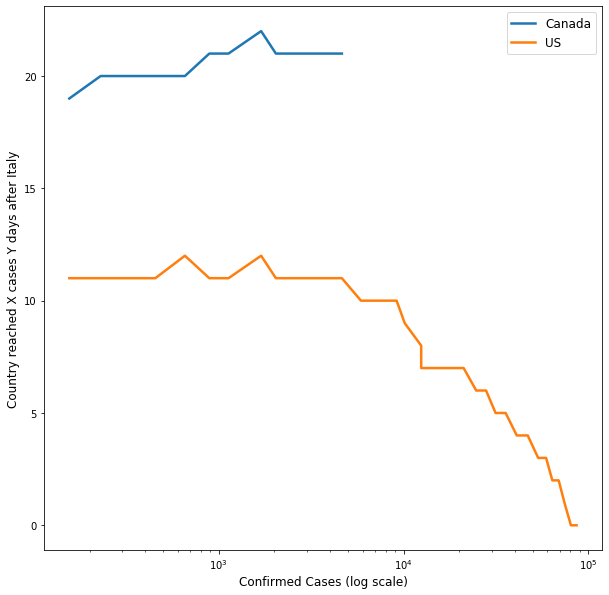

In [297]:
deltas = [[],[]]
vals = []
for i,v in enumerate(df['Italy']):
    if v<100:
        continue
    vals.append(v)
    for j,v2 in enumerate(df['Canada']):            
        if v2>=v:
            deltas[0].append(j-i)
            break
    for j,v2 in enumerate(df['US']):
        if v2>=v:
            deltas[1].append(j-i)
            break
print(deltas)
fig, ax = plt.subplots()
#ax.plot(zip(vals,deltas[0]))

ax.plot(vals[:len(deltas[0])],deltas[0], linewidth=2.5)
ax.plot(vals[:len(deltas[1])],deltas[1], linewidth=2.5)
font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)
ax.legend(['Canada','US'], prop=font)
ax.set_xscale('log')
ax.set_xlabel('Confirmed Cases (log scale)', size=12)
ax.set_ylabel('Country reached X cases Y days after Italy', size=12)

Text(0, 0.5, 'Confirmed cases')

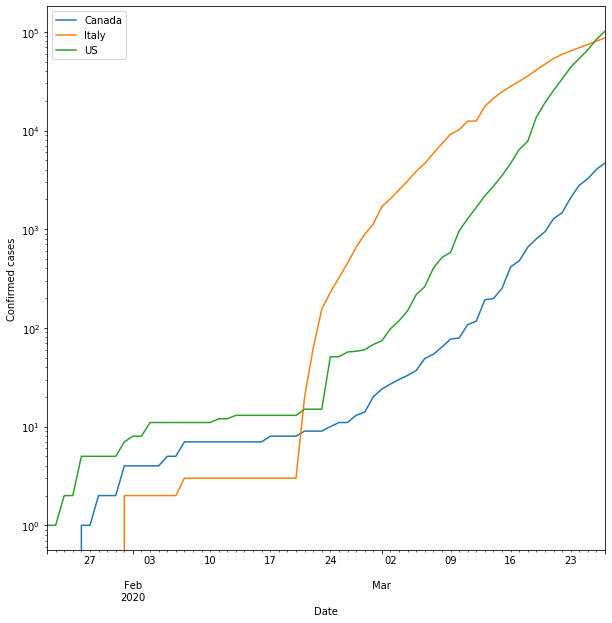

In [298]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10, 10]

ax=df.plot(legend=True,logy=True) #list(df.columns))
ax.set_xlabel('Date')
ax.set_ylabel('Confirmed cases')


In [299]:
df=raw.groupby('Country/Region').sum()
# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]

df = df[(df.index.isin(['Mexico']))]

df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
df

,Mexico
date,
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
...,...
2020-03-23,316
2020-03-24,367
2020-03-25,405


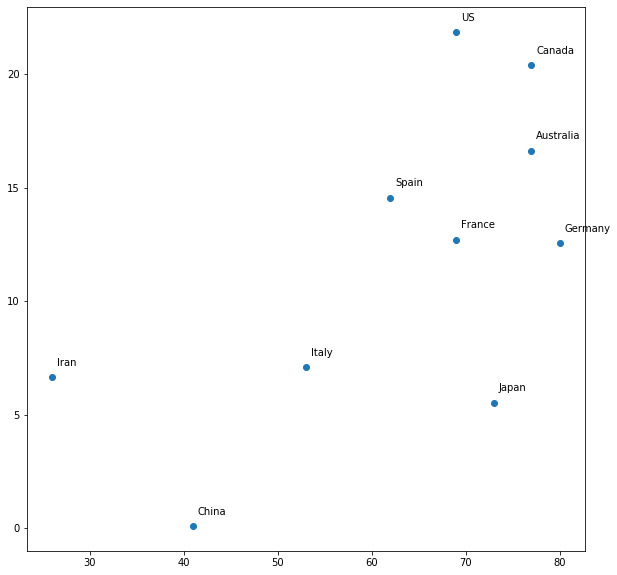

In [300]:
cpi = pd.read_csv('../cpi/cpi.tsv',sep='\t')
cpi = dict(zip(cpi['Country'],cpi['CPI score 2019']))
cpi
check = [c for c in growth if c not in cpi]
cpi['US'] = cpi['United States of America']

x= [cpi[c] for c in growth]
y = [growth[c][-1] for c in growth]
fig, ax = plt.subplots()
ax.scatter(x, y)
for i, txt in enumerate(growth):
    ax.annotate(txt, (x[i]+0.5,y[i]+0.5))

In [301]:
df=raw
# temporarily drop 03/14
#del df[df.columns[-1]]
#df = df[df['Country/Region'].isin(['Canada','US','Italy'])]

df=df.groupby('Country/Region').sum()


df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)


df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]

matrix = {}

for c in sorted(df.columns, key=lambda c: df[c][-1], reverse=True):
    if max(df[c])<1000:
        continue
    matrix[c]={}
    last1 = df[c][-1]
    for c2 in sorted(df.columns, key=lambda c: df[c][-1], reverse=True):
        if max(df[c2])<1000:
            continue
        if c2==c:
            matrix[c][c2]=0
            continue
        last2 = df[c2][-1]
        if last2<=last1:
            for j,v2 in enumerate(df[c]):            
                if v2>=last2:
                    matrix[c][c2]=len(df[c])-j-1
                    break
        else:
            for j,v2 in enumerate(df[c2]):            
                if v2>=last1:
                    matrix[c][c2]=-(len(df[c2])-j-1)
                    break
result=pd.DataFrame.from_dict(matrix)
result.to_csv('lagtimes.tsv', sep='\t')

Text(0.5, 0, 'count per 1,000 pop.')

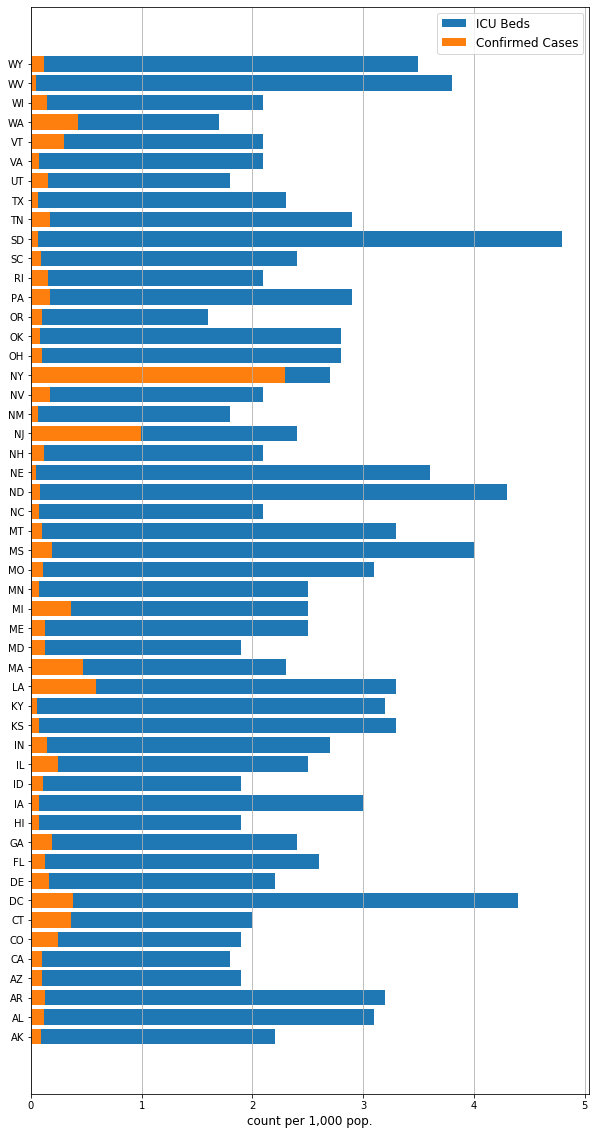

In [302]:
covidtracking = pd.read_csv('../other3p/covidtracking_daily.csv')
covidtracking['date'] = pd.to_datetime(covidtracking['date'],format="%Y%m%d")
maxDate = max(covidtracking['date'])
df = covidtracking.pivot(index='date',columns='state', values='positive')
df = df.replace(np.nan,0)
icu = pd.read_csv('../other3p/icu.csv',skiprows=2)
statecodes = pd.read_csv('../expdev07/statecodes.tsv', sep='\t',names=['Abbrev','State'])
statecodes = dict(zip(statecodes['State'],statecodes['Abbrev']))
index = [statecodes[c] if c in statecodes else None for c in icu['Location']]
icu = dict([(l,t) for (l,t) in zip(index,icu['Total'])])

pop = pd.read_csv('../other3p/state_pop.txt', sep='\t', names=['State','Pop'])
pop = dict(zip([statecodes[c.replace('.','')] for c in pop['State']],pop['Pop']))
#icu
cols = [c for c in df.columns if c in icu]
data = list(zip(cols, [max(df[c])*1e3/pop[c] for c in cols], [icu[c] for c in cols]))

plt.rcParams["figure.figsize"] = [10, 20]
fig, ax = plt.subplots()
labels = [c for (c,_,_) in data]
ax.grid(b=True,axis='x')
ax.barh(labels, [x for (_,_,x) in data])
ax.barh(labels, [x for (_,x,_) in data])
font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)
ax.legend(['ICU Beds','Confirmed Cases'], prop=font)
ax.set_xlabel('count per 1,000 pop.', size=12)

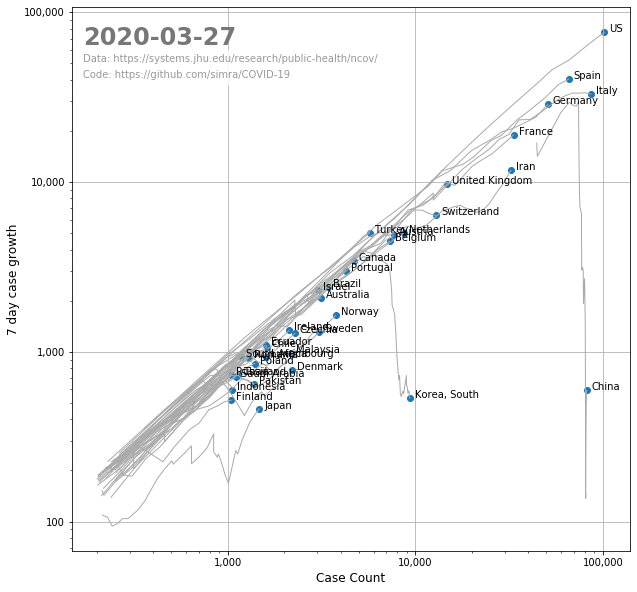

In [305]:
df=raw.groupby('Country/Region').sum()
# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]

df = df[(df.index.isin(['Canada','Japan', 'Australia'])) | (df[last_date]>1000)]

df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
#del df['Cruise Ship']
maxDate=max(df.index)

plt.rcParams["figure.figsize"] = [10, 10]
fig, ax = plt.subplots()
growth = {}
points = []
markers = [item for sublist in ['oxds+*']*ceil(len(df.columns)/5) for item in sublist]    
start = 20
for c,m in zip(df.columns,markers):
    #growth[c] = [(pow(df[c][i]/max(1.0,df[c][i-6]),1.0/7)-1)*100 if df[c][i]>200 else float('nan') for i in range(20,len(df[c]))]
    growth[c] = [df[c][i]-df[c][i-6] if df[c][i]>200 else float('nan') for i in range(start,len(df[c]))]
    #growth[c] = [growth[c][i] if growth[c][i]<100 else float('nan') for i in range(len(growth[c]))]
    ax.plot(df[c][start:], growth[c], linewidth=1,color='#aaaaaa')
    points.append([df[c][-1],growth[c][-1],c])

ax.scatter([p[0] for p in points],[p[1] for p in points])   
for (x,y,txt) in points:
    ax.annotate(txt,(x,y), xytext=(5,0), textcoords='offset points')
font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)


ax.grid() 
ax.set_xscale('log')
ax.set_yscale('log')
ax.get_xaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#ax.yaxis.set_label_position("right")
#ax.set_ylim([0,50])
ax.set_xlabel('Case Count', size=12)
ax.set_ylabel('7 day case growth', size=12)
#ax.legend(df.columns, prop=font)    
#plt.ylim((0,100))
ax.text(0.02, 0.93, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='left', weight=800)
ax.text(0.02, 0.90, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='left', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.02, 0.87, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='left', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
save_figure(maxDate,'10_countvsgrowth.png')

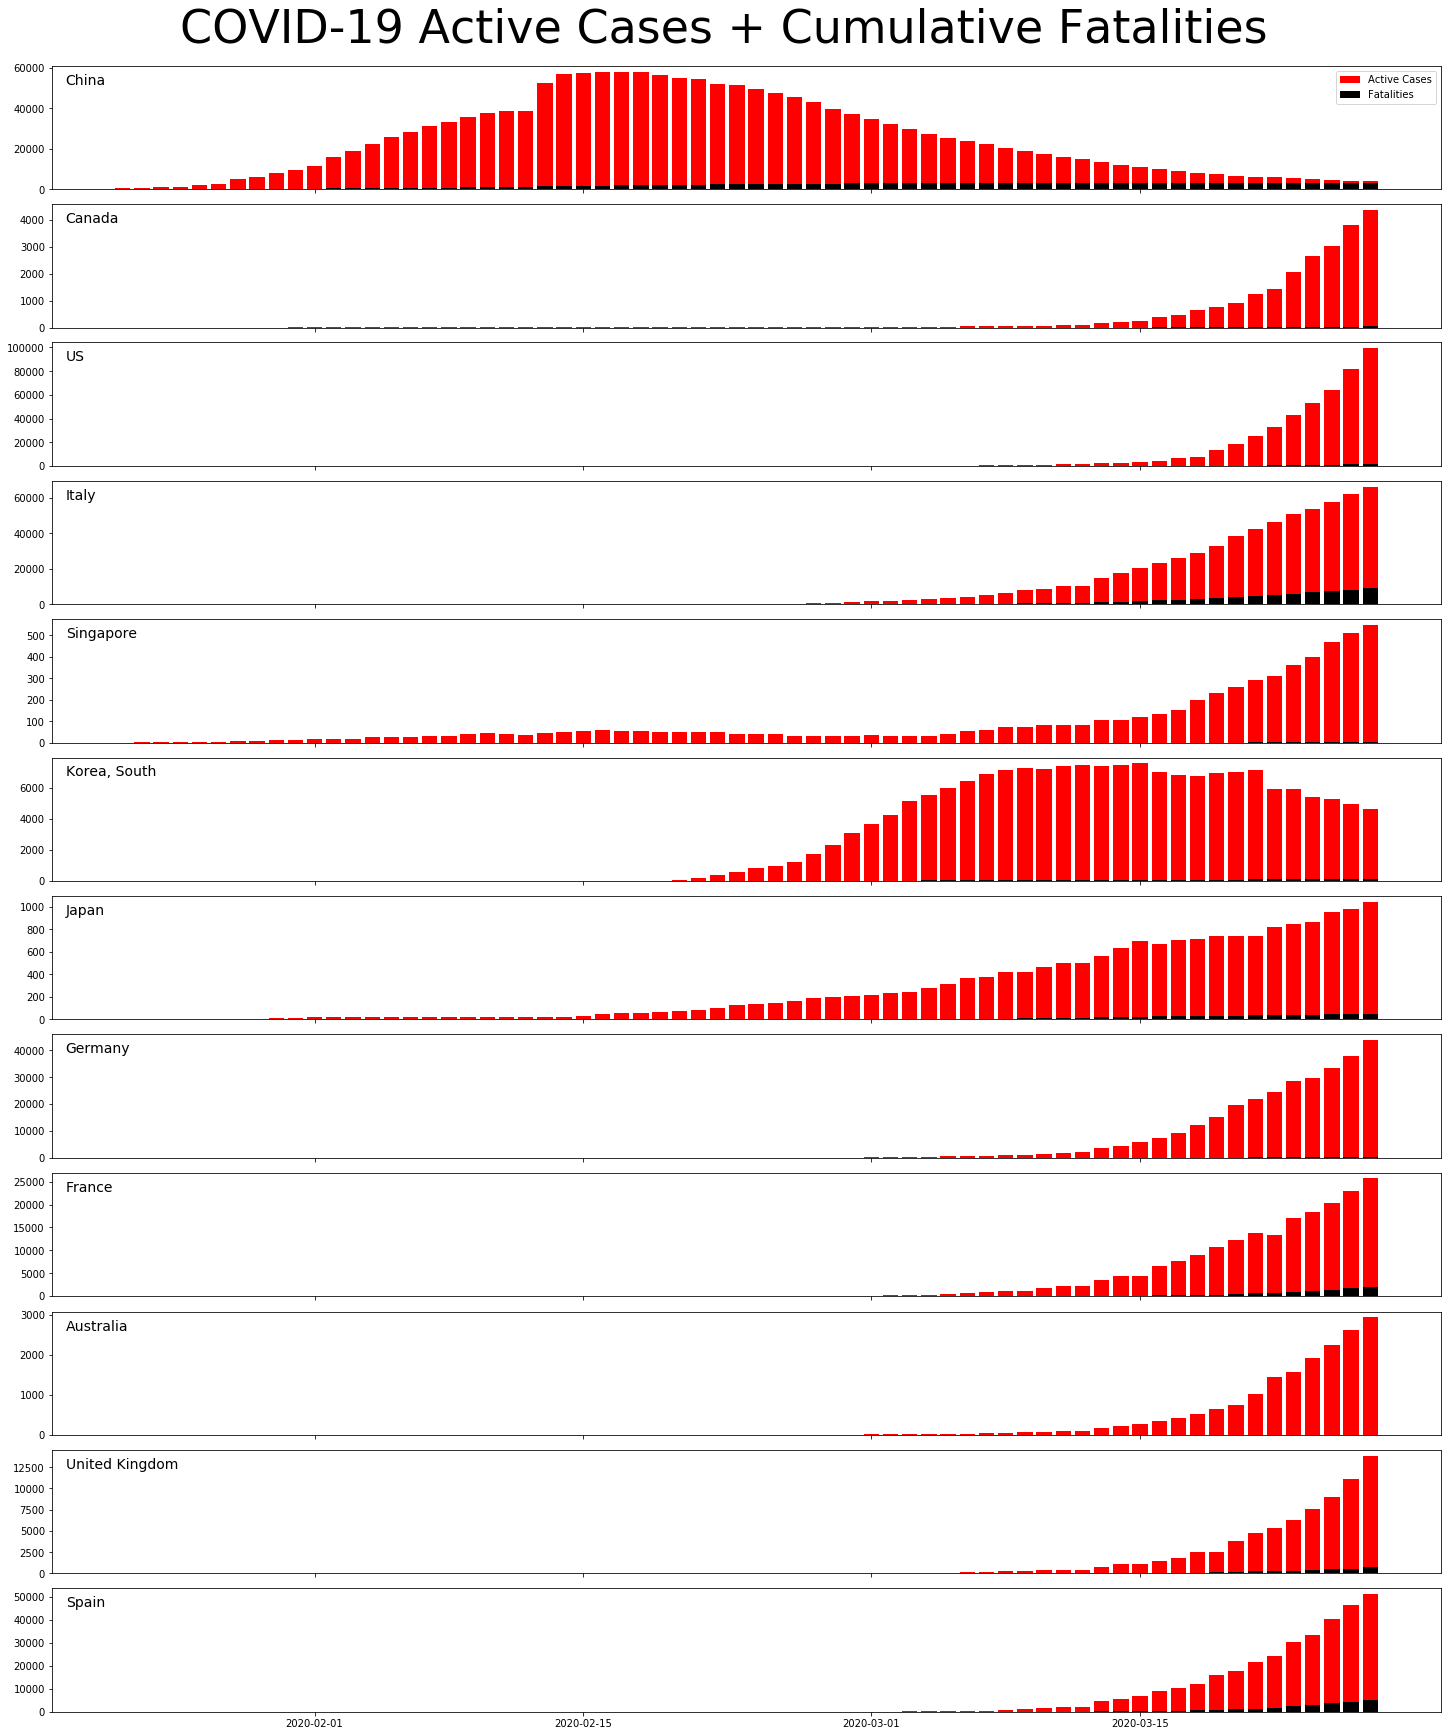

In [304]:


def prepData(datapath):
    raw = pd.read_csv(datapath)
    del raw['Lat']
    del raw['Long']
    raw= raw.replace('Mainland China','China')
    df=raw.groupby('Country/Region').sum()
    # 03/14: temporarily drop the last column
    #del df[df.columns[-1]]
    last_date = list(df.columns)[-1]

    #df = df[(df.index.isin(['Canada','Japan'])) | (df[last_date]>100)]

    df['Country/Region']=df.index
    df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
    df['date']=pd.to_datetime(df.index)

    df.index.name = None
    df=df.sort_values(by=['date'])
    df.set_index('date', inplace=True)
    df.columns = [c[1] for c in df.columns]
    return df

deaths = prepData('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered = prepData('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
confirmed = prepData('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')


def plotBars(countries):
    plt.rcParams["figure.figsize"] = [20, 2*len(countries)]
    fig, axs = plt.subplots(len(countries),1, sharex=True,constrained_layout=True)
    for (i,(country,ax)) in enumerate(zip(countries,axs)):
        active = []
        for (c,r,d) in zip(confirmed[country], recovered[country], deaths[country]):
            active.append(c-r-d)
        ax.bar(confirmed.index,active, color='red')
        rec = []
        for (r,d) in zip(recovered[country],deaths[country]):
            rec.append(r+d)
        #ax.bar(recovered.index,rec, color='green')
        ax.bar(deaths.index, deaths[country], color='black')
        #ax.set_yscale('log')
        ax.text(0.01,0.85,country, transform=ax.transAxes, ha='left', size=14)
        fig.suptitle('COVID-19 Active Cases + Cumulative Fatalities',size=46)
        if i==0:
            ax.legend(['Active Cases','Fatalities'])


plotBars(['China','Canada','US','Italy','Singapore','Korea, South','Japan','Germany','France','Australia','United Kingdom','Spain'])

maxDate = confirmed.index[-1]
#print(maxDate)
save_figure(maxDate,'5_barplots.png')